## Linear Regression - Introduction

Linear regression relates a continuous response (dependent) variable to one or more predictors (features, independent variables), using the assumption that the relationship is linear in nature:
- The relationship between each feature and the response is a straight line when we keep other features constant.
- The slope of this line does not depend on the values of the other variables.
- The effects of each variable on the response are additive (but we can include new variables that represent the interaction of two variables).

In other words, the model assumes that the response variable can be explained or predicted by a linear combination of the features, except for random deviations from this linear relationship.

In [10]:
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import statsmodels.api as sm
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

### Simple Regression

#### Generate random data

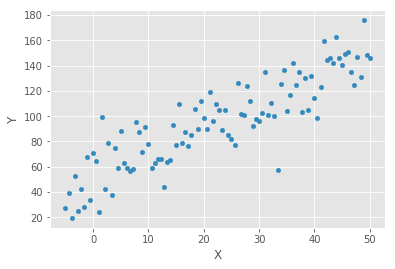

In [11]:
x = np.linspace(-5, 50, 100)
y = 50 + 2 * x  + np.random.normal(0, 20, size=len(x))
data = pd.DataFrame({'X': x, 'Y': y})
ax = data.plot.scatter(x='X', y='Y');

Our linear model with a single independent variable on the left-hand side assumes the following form:

$$y = \beta_0 + \beta_1 X_1 + \epsilon$$

$\epsilon$ accounts for the deviations or errors that we will encounter when our data do not actually fit a straight line. When $\epsilon$ materializes, that is when we run the model of this type on actual data, the errors are called **residuals**.

#### Estimate a simple regression with statsmodels

In [12]:
X = sm.add_constant(data['X'])
model = sm.OLS(data['Y'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     338.5
Date:                Wed, 31 Oct 2018   Prob (F-statistic):           1.47e-33
Time:                        14:50:41   Log-Likelihood:                -424.35
No. Observations:                 100   AIC:                             852.7
Df Residuals:                      98   BIC:                             857.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.3829      2.933     17.518      0.0

#### Verify calculation

In [13]:
beta = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))
pd.Series(beta, index=X.columns)

const   51.38
X        1.95
dtype: float64

#### Display model & residuals

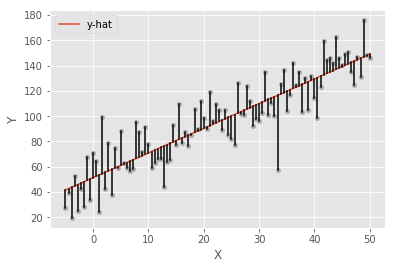

In [14]:
data['y-hat'] = model.predict()
data['residuals'] = model.resid
ax = data.plot.scatter(x='X', y='Y', c='darkgrey')
data.plot.line(x='X', y='y-hat', ax=ax);
for _, row in data.iterrows():
    plt.plot((row.X, row.X), (row.Y, row['y-hat']), 'k-')    

### Multiple Regression


For two independent variables, the model simply changes as follows:

$$y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \epsilon$$

#### Generate new random data

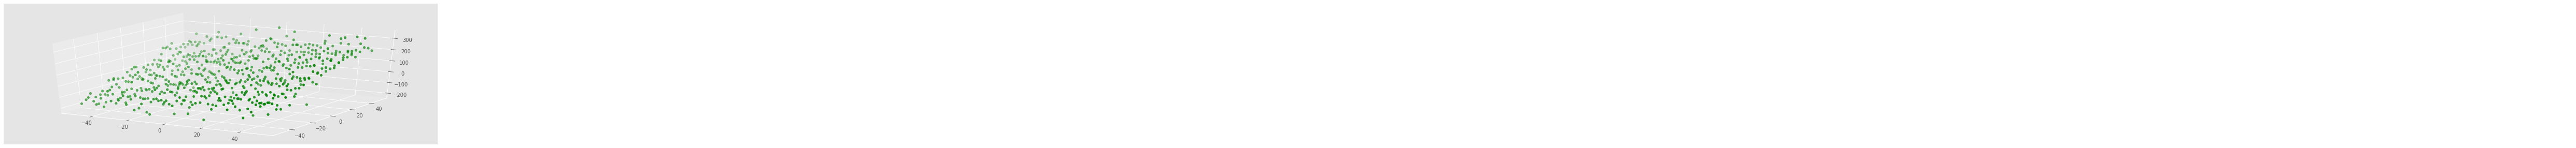

In [15]:
## Create data
size = 25
X_1, X_2 = np.meshgrid(np.linspace(-50, 50, size), np.linspace(-50, 50, size), indexing='ij')
data = pd.DataFrame({'X_1': X_1.ravel(), 'X_2': X_2.ravel()})
data['Y'] = 50 + data.X_1 + 3 * data.X_2 + np.random.normal(0, 50, size=size**2)

## Plot
three_dee = plt.figure(figsize=(15, 5)).gca(projection='3d')
three_dee.scatter(data.X_1, data.X_2, data.Y, c='g');

In [16]:
X = data[['X_1', 'X_2']]
y = data['Y']

#### Estimate multiple regression model with statsmodels

In [17]:
X_ols = sm.add_constant(X)
model = sm.OLS(y, X_ols).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     1277.
Date:                Wed, 31 Oct 2018   Prob (F-statistic):          5.83e-221
Time:                        14:50:42   Log-Likelihood:                -3308.3
No. Observations:                 625   AIC:                             6623.
Df Residuals:                     622   BIC:                             6636.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.6751      1.931     26.248      0.0

#### Verify computation

In [18]:
beta = np.linalg.inv(X_ols.T.dot(X_ols)).dot(X_ols.T.dot(y))
pd.Series(beta, index=X_ols.columns)

const   50.68
X_1      0.97
X_2      3.10
dtype: float64

#### Save output as image

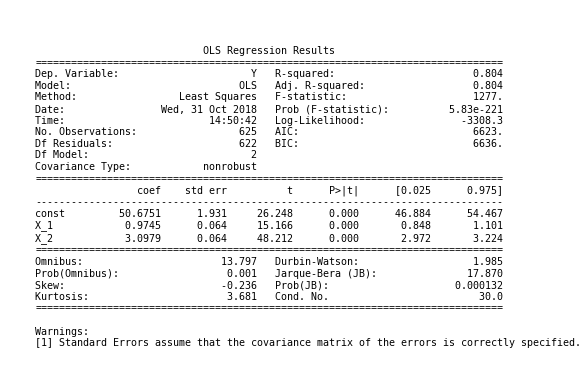

In [19]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 14}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.1)
plt.savefig('multiple_regression_summary.png', bbox_inches='tight', dpi=300);

#### Display model & residuals

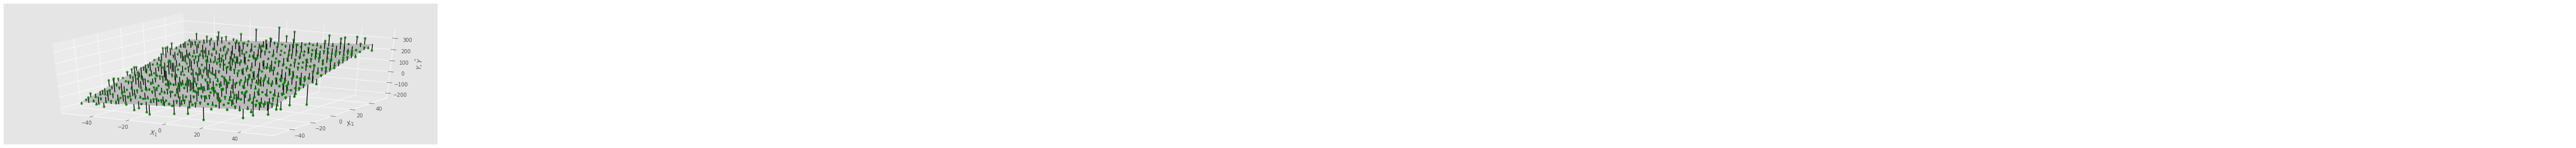

In [20]:
three_dee = plt.figure(figsize=(15, 5)).gca(projection='3d')
three_dee.scatter(data.X_1, data.X_2, data.Y, c='g')
data['y-hat'] = model.predict()
to_plot = data.set_index(['X_1', 'X_2']).unstack().loc[:, 'y-hat']
three_dee.plot_surface(X_1, X_2, to_plot.values, color='black', alpha=0.2, linewidth=1, antialiased=True)
for _, row in data.iterrows():
    plt.plot((row.X_1, row.X_1), (row.X_2, row.X_2), (row.Y, row['y-hat']), 'k-');
three_dee.set_xlabel('$X_1$');three_dee.set_ylabel('$X_2$');three_dee.set_zlabel('$Y, \hat{Y}$')
plt.savefig('multiple_regression_plot.png', dpi=300);

Additional [diagnostic tests](https://www.statsmodels.org/dev/diagnostic.html)

## Stochastic Gradient Descent Regression

### Prepare data

The gradient is sensitive to scale and so is SGDRegressor. Use the `StandardScaler` or `scale` to adjust the features. 

In [21]:
scaler = StandardScaler()
X_ = scaler.fit_transform(X)

### Configure SGDRegressor

In [22]:
sgd = SGDRegressor(loss='squared_loss', fit_intercept=True, 
                   shuffle=True, random_state=42,
                   learning_rate='invscaling', 
                   eta0=0.01, power_t=0.25)

### Fit Model

In [23]:
# sgd.n_iter = np.ceil(10**6 / len(y))
sgd.fit(X=X_, y=y)

/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [24]:
coeffs = (sgd.coef_ * scaler.scale_) + scaler.mean_
pd.Series(coeffs, index=X.columns)

X_1     882.83
X_2   2,795.73
dtype: float64

In [25]:
resids = pd.DataFrame({'sgd': y - sgd.predict(X_),
                      'ols': y - model.predict(sm.add_constant(X))})

In [26]:
resids.pow(2).sum().div(len(y)).pow(.5)

ols   48.15
sgd   48.15
dtype: float64

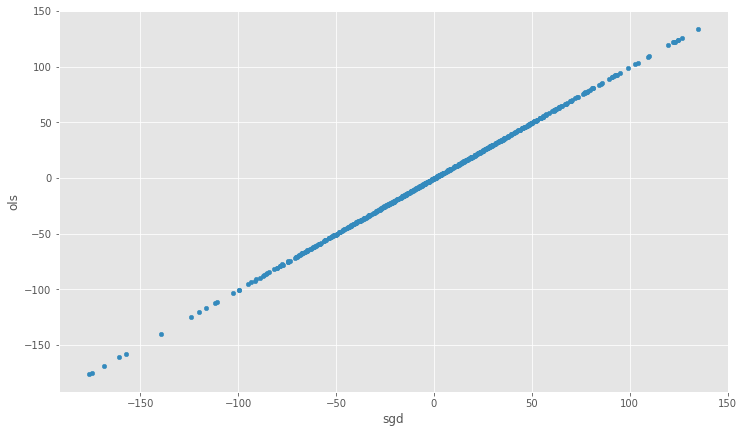

In [27]:
resids.plot.scatter(x='sgd', y='ols');